In [9]:
import os
import torch
import numpy as np
import evaluate
from transformers import (
    AutoFeatureExtractor,
    AutoModelForAudioClassification,
    TrainingArguments,
    Trainer
)
# Bỏ PEFT/LoRA vì không hoạt động đúng với Whisper

In [10]:
data_path = "../DATASET_LABELED" 
output_dir = "./whisper_ser_checkpoint"
# Dùng model nhỏ nhất để tránh lỗi out of memory
model_id = "openai/whisper-base"  # ~74M params, rất nhẹ

# Kiểm tra GPU
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    
# Giải phóng bộ nhớ trước khi load model
import gc
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

CUDA Available: True
Device: NVIDIA GeForce RTX 3050 Laptop GPU


In [11]:
import torchaudio
from torch.utils.data import Dataset, random_split

class AudioDataset(Dataset):
    def __init__(self, data_dir, target_sr=16000):
        self.data_dir = data_dir
        self.target_sr = target_sr
        self.samples = []
        self.labels = []
        self.label_names = []
        
        # Lấy danh sách các thư mục con (mỗi thư mục là 1 label)
        for label_name in sorted(os.listdir(data_dir)):
            label_path = os.path.join(data_dir, label_name)
            if os.path.isdir(label_path):
                if label_name not in self.label_names:
                    self.label_names.append(label_name)
                label_id = self.label_names.index(label_name)
                
                # Lấy tất cả file audio trong thư mục
                for file_name in os.listdir(label_path):
                    if file_name.endswith(('.wav', '.mp3', '.flac', '.ogg')):
                        self.samples.append(os.path.join(label_path, file_name))
                        self.labels.append(label_id)
        
        print(f"📂 Tìm thấy {len(self.samples)} file audio với {len(self.label_names)} nhãn")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        audio_path = self.samples[idx]
        label = self.labels[idx]
        
        # Load audio
        waveform, sr = torchaudio.load(audio_path)
        
        # Resample nếu cần
        if sr != self.target_sr:
            resampler = torchaudio.transforms.Resample(sr, self.target_sr)
            waveform = resampler(waveform)
        
        # Chuyển về mono nếu stereo
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        
        return {
            "audio": {"array": waveform.squeeze().numpy(), "sampling_rate": self.target_sr},
            "label": label
        }

print("⏳ Đang load dataset...")
full_dataset = AudioDataset(data_path)

# Chia train/test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], 
                                            generator=torch.Generator().manual_seed(42))

# Lấy nhãn
labels = full_dataset.label_names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(f"✅ Đã tải xong! Các nhãn: {labels}")
print(f"📊 Train: {len(train_dataset)}, Test: {len(test_dataset)}")

⏳ Đang load dataset...
📂 Tìm thấy 977 file audio với 5 nhãn
✅ Đã tải xong! Các nhãn: ['ANG', 'ANX', 'HAP', 'NEU', 'SAD']
📊 Train: 781, Test: 196


In [12]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

class PreprocessedDataset(Dataset):
    def __init__(self, subset, feature_extractor, max_length=16000*30):
        self.subset = subset
        self.feature_extractor = feature_extractor
        self.max_length = max_length
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        item = self.subset[idx]
        audio_array = item["audio"]["array"]
        
        inputs = self.feature_extractor(
            audio_array,
            sampling_rate=16000,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="np"
        )
        
        return {
            "input_features": inputs["input_features"].squeeze(0),
            "labels": item["label"]
        }

# Wrap datasets với preprocessing
encoded_train = PreprocessedDataset(train_dataset, feature_extractor)
encoded_test = PreprocessedDataset(test_dataset, feature_extractor)

print("✅ Đã cấu hình Preprocessing!")

✅ Đã cấu hình Preprocessing!


In [13]:
print("⏳ Đang tải model (có thể mất vài phút)...")

# Giải phóng bộ nhớ trước
import gc
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Load model
model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True
)

# Chuyển model lên GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Tắt cache
model.config.use_cache = False

# FREEZE encoder, chỉ train classifier head
# Freeze tất cả layers của encoder
for param in model.encoder.parameters():
    param.requires_grad = False

# Unfreeze projector và classifier (sẽ được train)
for param in model.projector.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Đếm trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Trainable params: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")
print(f"✅ Model loaded on {device}")

⏳ Đang tải model (có thể mất vài phút)...


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Trainable params: 132,613 / 20,723,205 (0.64%)
✅ Model loaded on cuda


In [14]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

# Tính class weights MẠNH HƠN để cân bằng các class
from collections import Counter
train_labels = [full_dataset.labels[i] for i in train_dataset.indices]
label_counts = Counter(train_labels)
total_samples = len(train_labels)
num_classes = len(labels)

# Class weight mạnh hơn: sqrt hoặc log scale
# Dùng inverse frequency với power để boost minority classes
max_count = max(label_counts.values())
class_weights = torch.tensor([
    (max_count / label_counts[i]) ** 0.75  # Power 0.75 để boost minority classes
    for i in range(num_classes)
], dtype=torch.float32).to(device)

print("⚖️ Class weights để cân bằng (boosted):")
for i, label_name in enumerate(labels):
    print(f"  {label_name}: {class_weights[i].item():.3f} (count: {label_counts[i]})")

# Focal Loss để focus vào hard examples
class FocalLoss(torch.nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss

# Custom Trainer với Focal Loss
class FocalTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal_loss = FocalLoss(weight=class_weights, gamma=2.0)
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels_batch = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Focal Loss thay vì Cross Entropy
        loss = self.focal_loss(logits, labels_batch)
        
        return (loss, outputs) if return_outputs else loss

def data_collator(features):
    input_features = [f["input_features"] for f in features] 
    labels_list = [f["labels"] for f in features]
    
    batch = {
        "input_features": torch.tensor(np.array(input_features), dtype=torch.float32),
        "labels": torch.tensor(np.array(labels_list), dtype=torch.long)
    }
    return batch

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=5e-4,  # Learning rate cao hơn
    per_device_train_batch_size=4,  # Tăng batch size
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=4,
    num_train_epochs=30,  # Tăng epochs
    eval_strategy="epoch", 
    save_strategy="epoch",
    logging_steps=5,
    fp16=False,
    remove_unused_columns=False, 
    label_names=["labels"],
    dataloader_num_workers=0,
    save_total_limit=2,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.05,  # Tăng regularization
    lr_scheduler_type="cosine",  # Cosine scheduler
)

trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("✅ Đã cấu hình Trainer với Focal Loss + Boosted Class Weights!")

⚖️ Class weights để cân bằng (boosted):
  ANG: 1.659 (count: 166)
  ANX: 2.562 (count: 93)
  HAP: 2.103 (count: 121)
  NEU: 1.000 (count: 326)
  SAD: 3.010 (count: 75)
✅ Đã cấu hình Trainer với Focal Loss + Boosted Class Weights!


In [ ]:
if __name__ == "__main__":
    print("🚀 Đang bắt đầu training trên máy local...")
    trainer.train()
    
    # Lưu model sau khi train xong
    print("💾 Đang lưu model...")
    trainer.save_model(output_dir + "/final_model")
    print("🎉 Hoàn tất!")

🚀 Đang bắt đầu training trên máy local...


Epoch,Training Loss,Validation Loss,Accuracy
1,2.181100,2.652267,0.377551
2,2.045300,2.430493,0.336735
3,2.205600,2.265926,0.372449
4,2.046500,2.195022,0.454082
5,1.848800,2.135574,0.535714
6,2.158700,1.881158,0.464286


e:\anaconda3\envs\venv\Lib\site-packages\transformers\configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 5

📊 Đang đánh giá model trên tập test...

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

         ANG       0.46      0.50      0.48        38
         ANX       0.00      0.00      0.00        31
         HAP       0.50      0.37      0.43        27
         NEU       0.48      0.80      0.60        74
         SAD       0.54      0.27      0.36        26

    accuracy                           0.48       196
   macro avg       0.40      0.39      0.37       196
weighted avg       0.41      0.48      0.43       196


🔢 CONFUSION MATRIX


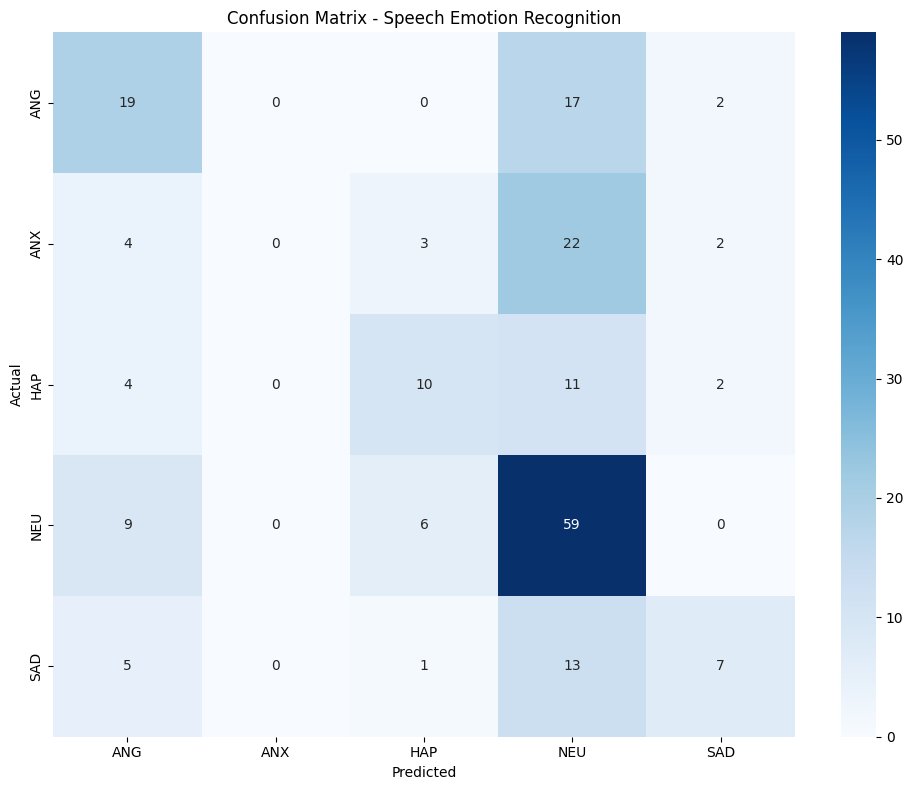


📈 PHÂN BỐ DỮ LIỆU THEO CLASS
  ANG: 38 samples
  ANX: 31 samples
  HAP: 27 samples
  NEU: 74 samples
  SAD: 26 samples

🎯 ACCURACY THEO TỪNG CLASS
  ANG: 50.00%
  ANX: 0.00%
  HAP: 37.04%
  NEU: 79.73%
  SAD: 26.92%


In [ ]:
# Đánh giá chi tiết model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 Đang đánh giá model trên tập test...")

# Lấy predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(len(encoded_test)):
        item = encoded_test[i]
        input_features = torch.tensor(item["input_features"]).unsqueeze(0).to(device)
        label = item["labels"]
        
        outputs = model(input_features=input_features)
        pred = torch.argmax(outputs.logits, dim=-1).item()
        
        all_preds.append(pred)
        all_labels.append(label)

# Classification Report
print("\n" + "="*60)
print("📋 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=labels, zero_division=0))

# Confusion Matrix
print("\n" + "="*60)
print("🔢 CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Speech Emotion Recognition')
plt.tight_layout()
plt.show()

# Hiển thị số lượng mỗi class
print("\n" + "="*60)
print("📈 PHÂN BỐ DỮ LIỆU THEO CLASS")
print("="*60)
from collections import Counter
label_counts = Counter(all_labels)
for label_id, count in sorted(label_counts.items()):
    print(f"  {labels[label_id]}: {count} samples")

# Accuracy theo từng class
print("\n" + "="*60)
print("🎯 ACCURACY THEO TỪNG CLASS")
print("="*60)
for i, label_name in enumerate(labels):
    class_mask = [l == i for l in all_labels]
    class_preds = [p for p, m in zip(all_preds, class_mask) if m]
    class_labels = [l for l, m in zip(all_labels, class_mask) if m]
    if len(class_labels) > 0:
        acc = sum(p == l for p, l in zip(class_preds, class_labels)) / len(class_labels)
        print(f"  {label_name}: {acc*100:.2f}%")